In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
from implementations import *

%load_ext autoreload
%autoreload 2

# **Load and clean the training data**

We load the training data.

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


For each feature, we clean the data so the values make more sense

In [3]:
#TODO : clean the data by calling the associated function in the implementations.py
x_train[:,6] = replace(x_train[:,6], [1100,1200], [1,0])
x_train[:,13] = replace(x_train[:,13], [0,1], [1,2])
x_train[:,24] = replace(x_train[:,24], [1,2,7,9], [0,1,np.nan,np.nan])
x_train[:,25] = replace(x_train[:,25], [77,99], [np.nan,np.nan])
x_train[:,26] = replace(x_train[:,26], [2,3,4,5,7,9], [0.75,0.5,0.25,0,np.nan,np.nan])

array_1 = [27,28,29]

for i in array_1 : 
    x_train[:,i] = replace(x_train[:,i], [88,77,99], [np.nan,np.nan,np.nan])

x_train[:,31] = replace(x_train[:,31], [3,7,9], [0,np.nan,np.nan])

array_2 = [30,32,34,35,36,38,39,40,41,42,43,44,45,46,47,48,53,54,55,56,57,61,64,65,66,67,68,69,70,71,72,73,74,87,95,96,100,103,104,107,108,116,117,118]
           
for i in array_2:
    x_train[:,i] = replace(x_train[:,i], [7,9], [np.nan,np.nan])
    

x_train[:,33] = replace(x_train[:,33], [1,2,3,4,7,8,9], [6,18,42,60,np.nan,120,np.nan])
x_train[:,37] = replace(x_train[:,37], [1,2,3,4,7,9], [6,18,42,60,np.nan,np.nan])
x_train[:,49] = replace(x_train[:,49], [98,99], [np.nan,np.nan])

array_3 = [51,52,58]

for i in array_3 : 
    x_train[:,i] = replace(x_train[:,i], [9], [np.nan])
    
x_train[:,59] = replace(x_train[:,59], [88,99], [0,np.nan])
x_train[:,60] = replace(x_train[:,60], [1,2,3,4,5,6,7,8,77,99] , [5,12.5,17.5,22.5,30,42.5,62.5,75,np.nan,np.nan])

x_train[:,62] = replace(x_train[:,62], [7777,9999], [np.nan,np.nan])    
x_train[:,62] = list(map(IntoPounds,(x_train[:, 62])))

x_train[:,63] = replace(x_train[:,63], [7777,9999], [np.nan,np.nan])    
x_train[:,63] = list(map(IntoInches,(x_train[:, 63])))

x_train[:,75] = replace(x_train[:,75],[1,2,3,4,5,6,7,8,77,99] , [15,60,135,270,1080,2070,3600,np.nan,np.nan,np.nan])
x_train[:,76] = replace(x_train[:,76],[3,7,9] ,[0,np.nan,np.nan])
x_train[:,77] = replace(x_train[:,77],[777,888,999] ,[np.nan,0,np.nan])
x_train[:,77] = list(map(WeekToMonth,(x_train[:, 77])))


array_5 = [78,80,88,91,98,119]

for i in array_5 :
    x_train[:,i] = replace(x_train[:,i], [77,99], [np.nan,np.nan])
    
x_train[:,79] = replace(x_train[:,79],[77,88,99] ,[np.nan,0,np.nan])

array_6 = [81,82,83,84,85,86]

for i in array_6 :
    x_train[:,i] = replace(x_train[:,i], [300,555,777,999], [0,0,np.nan,np.nan])
    x_train[:,i] = list(map(DayToMonth,(x_train[:, i])))
    
array_7 = [89,90,92,93] 

for i in array_7 :
    x_train[:,i] = replace(x_train[:,i], [777,999],  [0,0,np.nan,np.nan])

x_train[:,89] = list(map(WeekToMonth,(x_train[:, 89])))
x_train[:,90] = list(map(HourToMinutes,(x_train[:, 90])))
x_train[:,92] = list(map(HourToMinutes,(x_train[:, 92])))

array_8 = [94,110,111] 

for i in array_8 :
    x_train[:,i] = replace(x_train[:,i], [777,888,999], [np.nan,0,np.nan])

x_train[:,94] = replace(x_train[:,94], [777,888,999], [np.nan,0,np.nan])
x_train[:,94] = list(map(WeekToMonth,(x_train[:, 94])))
x_train[:,97] = replace(x_train[:,97], [2,3,7,9], [0.5,0,np.nan,np.nan])
x_train[:,99] = replace(x_train[:,99], [2,3,4,5,7,8,9], [0.75,0.5,0.25,0,np.nan,np.nan,np.nan])
x_train[:,101] = replace(x_train[:,101], [777777, 999999],  [np.nan,np.nan])

#x_train[:,101] = list(map(DateType,(x_train[:, 101])))

x_train[:,105] = replace(x_train[:,105], [777777, 999999],  [np.nan,np.nan])
#x_train[:,105] = list(map(DateType,(x_train[:, 105])))

x_train[:,110] = list(map(DayToYear,(x_train[:, 110])))
x_train[:,111] = list(map(DayToYear,(x_train[:, 111])))

x_train[:,113] = replace(x_train[:,113],[77,88,98,99] ,[np.nan,0,np.nan,np.nan])
x_train[:,114] = replace(x_train[:,114],[77,88,99] ,[np.nan,0,np.nan])
x_train[:,115] = replace(x_train[:,114],[1,2,3,4,7,8,9] ,[15,180,540,720,np.nan,0,np.nan])

In [4]:
x_train[:, 240] = replace(x_train[:, 240], [np.nan, 77, 99], [-1, -1, -1])
x_train[:, 246] = replace(x_train[:, 246], [np.nan, 14], [-1, -1])
x_train[:, 247] = replace(x_train[:, 247], [np.nan, 3], [-1, -1])
x_train[:, 252] = replace(x_train[:, 252], [np.nan, 99999], [np.nan, np.nan])
x_train[:, 261] = replace(x_train[:, 261], [np.nan, 7, 9], [-1, -1, -1])
x_train[:, 262] = replace(x_train[:, 262], [np.nan, 900], [-1, -1])
x_train[:, 298] = replace(x_train[:, 298], [np.nan, 9], [1, 1])

rep_one = [241, 242, 243, 244, 255, 256, 257, 258, 259, 260, 263, 265, 278, 279, 284, 
          305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320]

for i in rep_one : 
    x_train[:, i] = replace(x_train[:, i], [np.nan, 9], [-1, -1])
    
rep_two = [245, 249, 254, 289, 290, 291, 292]

for i in rep_two : 
    x_train[:, i] = replace(x_train[:, i], [np.nan], [-1])
    

x_train[:, 264] = replace(x_train[:, 264], [np.nan, 99900], [-1, -1])
x_train[:, 287] = replace(x_train[:, 287], [np.nan, 99900], [-1, -1])
x_train[:, 288] = replace(x_train[:, 288], [np.nan, 99900], [-1, -1])

x_train[:, 272] = replace(x_train[:, 272], [np.nan], [0])
x_train[:, 273] = replace(x_train[:, 273], [np.nan], [0])

x_train[:, 274] = replace(x_train[:, 274], [np.nan], [1])
x_train[:, 275] = replace(x_train[:, 275], [np.nan], [1])
x_train[:, 280] = replace(x_train[:, 280], [np.nan], [1])
x_train[:, 281] = replace(x_train[:, 281], [np.nan], [1])

x_train[:, 282] = replace(x_train[:, 282], [np.nan], [2])
x_train[:, 283] = replace(x_train[:, 283], [np.nan], [2])

x_train[:, 293] = replace(x_train[:, 293], [np.nan, 99000], [np.nan, np.nan])
x_train[:, 294] = replace(x_train[:, 294], [np.nan, 99000], [np.nan, np.nan])
x_train[:, 297] = replace(x_train[:, 297], [np.nan, 99000], [np.nan, np.nan])

We then clean the data by : 
- removing the nan values by the mean of the rest of the feature
- removing the features where the variance is zero since they are constants for all samples
- remove the 8 first features as the appear weird in the task of predicting a heart attack

In [5]:
x_train, zero_var_features = gen_clean(x_train)
print(f"The data has now {x_train.shape[1]} features !")

The data has now 305 features !


# PCA algorithm implementation

In [6]:
pca_indices, idx = pca(x_train)
print(f"We can keep the {idx} first most influent features given by pca_indices")

We can keep the 124 first most influent features given by pca_indices


In [7]:
x_train_pca = x_train[:, pca_indices]
x_train_pca = x_train_pca[:, :(idx + 1)]
print(f"The data has now {x_train_pca.shape[1]} features")

The data has now 125 features


# Linear regression using stochastic gradient descent

We train our model using linear regression using SGD with mean-square error.

First, we separate our data in a training set(70%) and testing set(30%).

In [8]:
tx_tr, tx_te, y_tr, y_te = cross(x_train_pca, y_train, 0.7)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (229694, 125) ; tx_te shape : (98441, 125)
       y_tr : (229694,)     ;        y_te : (98441,)


Now we build our models for linear regression using SGD

In [9]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 126 features !


## Training 

Here we train our model using SGD with MSE

In [10]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.009

start_time = datetime.datetime.now()
w, loss = mean_squared_error_sgd(y, tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 52.140743 seconds


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

In [11]:
pred_data = np.dot(tx, w)

pred_data[pred_data > 0] = 1
pred_data[pred_data < 0] = -1

correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 86.03402788057154%
Precision: 27.350427350427353%
Recall : 35.472855941010536%
F1-score : 30.886566842615533%


Now we compute some metrics for our test data (40% of the total data)

In [12]:
pred_test = np.dot(tx_test, w)

pred_test[pred_test > 0] = 1
pred_test[pred_test < 0] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 85.99872004550949%
Precision: 27.87825319805911%
Recall : 36.04014598540146%
F1-score : 31.43809381684326%


### Feature analysis

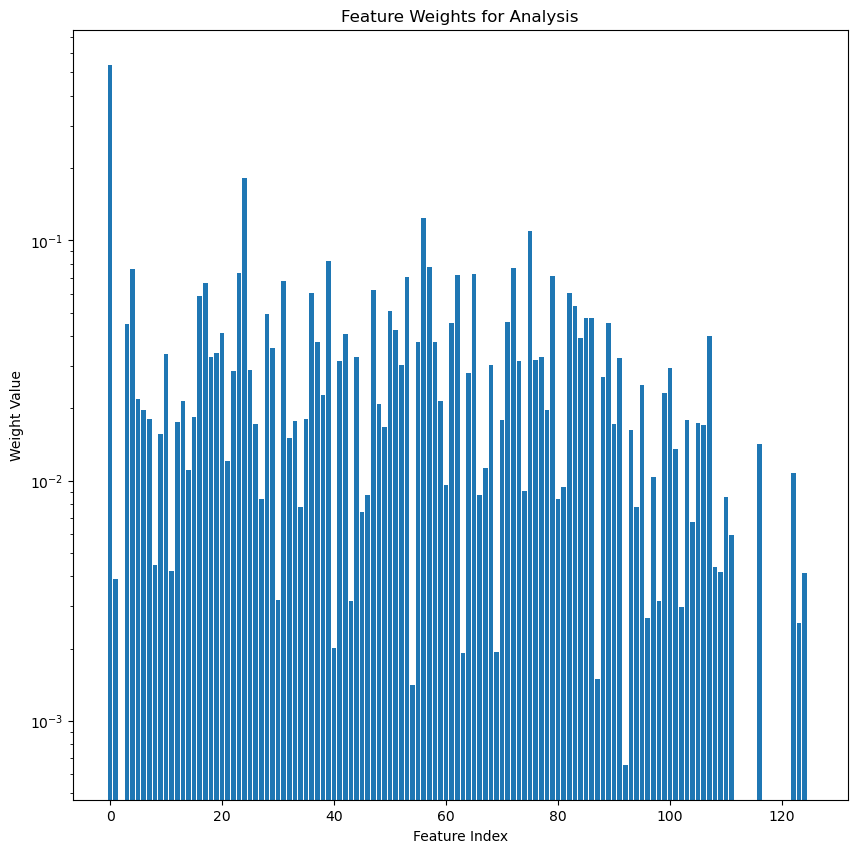

In [13]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(w)), np.abs(w))
plt.yscale('log')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

# Prediction on test data

In [19]:
start_time = datetime.datetime.now()

data_te = np.ones(x_test.shape)

for i in range(data_te.shape[1]):
    d, _ = standardize_clean(x_test[:, i])
    data_te[:, i] = d
    
data_var_te = data_te[:, zero_var_features]
data_var_te = np.squeeze(data_var_te, axis = 1)
data_cleaned_te = data_var_te[:, 9:]

data_test = data_cleaned_te[:, pca_indices]
data_test = data_test[:, :(idx + 1)]

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 1.955108 seconds


In [20]:
tx_te = np.c_[np.ones(data_test.shape[0]), data_test]
print(tx_te.shape)

(109379, 134)


In [21]:
y_te = np.dot(tx_te, w)
print(y_te.shape)

(109379,)


In [23]:
pred_te = y_te

pred_te[pred_te > 0] = 1
pred_te[pred_te < 0] = -1

indices_one = np.where(pred_te == 1)

In [24]:
create_csv_submission(test_ids, pred_te, "../data/sgd_reg.csv")